<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [23]:
# Importamos las librerias que utilizaremos en el codigo
import re
import unicodedata

import stanza
import spacy_stanza

import json
import string
import random 
import numpy as np

import tensorflow as tf 
from keras import Sequential 
from keras.layers import Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2023-07-13 14:47:27 INFO: Downloading default packages for language: es (Spanish)...
2023-07-13 14:47:28 INFO: File exists: C:\Users\Federico Delgado\stanza_resources\es\default.zip.
2023-07-13 14:47:31 INFO: Finished downloading models and saved to C:\Users\Federico Delgado\stanza_resources.
2023-07-13 14:47:31 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2023-07-13 14:47:31 INFO: Use device: cpu
2023-07-13 14:47:31 INFO: Loading: tokenize
2023-07-13 14:47:31 INFO: Loading: mwt
2023-07-13 14:47:31 INFO: Loading: pos
2023-07-13 14:47:31 INFO: Loading: lemma
2023-07-13 14:47:31 INFO: Loading: depparse
2023-07-13 14:47:32 INFO: Loading: ner
2023-07-13 14:47:33 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos
- Quitar caracteres especiales
- Quitar símbolos de puntuación

In [25]:

def preprocess_clean_text(text):    
    # Sacamos las tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Quitamos los caracteres especiales
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    text = re.sub(pattern, '', text)
    # Quitamos los caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [26]:
"""
Dataset en formato JSON que representa las posibles preguntas (patterns)
y las posibles respuestas por categoría (tag)
Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
"respones" son las respuestas predeterminadas posibles para cada tag
"""
with open('intents.json') as intents:
    dataset = json.load(intents)

### 4 - Preprocesamiento y armado del dataset

In [27]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocabulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [28]:
# Imprimo resultados
print("Clases:\n", classes, '\n', '-'*100)
print("Categorias:\n", doc_y)

Clases:
 ['Bienvenida', 'CongestiÃ³n nasal', 'Contacto', 'Cortes', 'Despedida', 'Diarrea', 'Dolor de cabeza', 'Dolor de garganta', 'Dolor de muela', 'ErupciÃ³n', 'Esguinces', 'Fiebre', 'Fractura', 'Golpe de calor', 'Moreton', 'Nombre', 'Picaduras', 'RCP', 'Tos'] 
 ----------------------------------------------------------------------------------------------------
Categorias:
 ['Bienvenida', 'Bienvenida', 'Bienvenida', 'Bienvenida', 'Bienvenida', 'Bienvenida', 'Nombre', 'Nombre', 'Nombre', 'Contacto', 'Contacto', 'Contacto', 'Contacto', 'Contacto', 'Contacto', 'Cortes', 'Cortes', 'Cortes', 'Cortes', 'Cortes', 'Picaduras', 'Picaduras', 'Picaduras', 'Esguinces', 'Esguinces', 'Fiebre', 'Fiebre', 'CongestiÃ³n nasal', 'CongestiÃ³n nasal', 'CongestiÃ³n nasal', 'Tos', 'Tos', 'Tos', 'Dolor de garganta', 'Dolor de garganta', 'Dolor de garganta', 'Moreton', 'Moreton', 'Moreton', 'Diarrea', 'Diarrea', 'Diarrea', 'Golpe de calor', 'Golpe de calor', 'Dolor de muela', 'Dolor de muela', 'Dolor de cabe

In [29]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### 5 - Entrenamiento del modelo

In [30]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (70,) output: 19


In [31]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               9088      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 19)                1235      
                                                                 
Total params: 18579 (72.57 KB)
Trainable params: 18579 (72.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [32]:
# Muestra las epochs del modelo al entrenar
hist = model.fit(x=train_X, y=train_y, epochs=300)

Epoch 1/300
2/2 [==============================] - 1s 4ms/step - loss: 2.9727 - accuracy: 0.0164
Epoch 2/300
2/2 [==============================] - 0s 3ms/step - loss: 2.9581 - accuracy: 0.0492
Epoch 3/300
2/2 [==============================] - 0s 3ms/step - loss: 2.9234 - accuracy: 0.0492
Epoch 4/300
2/2 [==============================] - 0s 4ms/step - loss: 2.9539 - accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 0s 3ms/step - loss: 2.9470 - accuracy: 0.0164
Epoch 6/300
2/2 [==============================] - 0s 3ms/step - loss: 2.9124 - accuracy: 0.0820
Epoch 7/300
2/2 [==============================] - 0s 3ms/step - loss: 2.8411 - accuracy: 0.1475
Epoch 8/300
2/2 [==============================] - 0s 4ms/step - loss: 2.9154 - accuracy: 0.0820
Epoch 9/300
2/2 [==============================] - 0s 3ms/step - loss: 2.7976 - accuracy: 0.1148
Epoch 10/300
2/2 [==============================] - 0s 3ms/step - loss: 2.8337 - accuracy: 0.1475
Epoch 11/300
2/2 [=======

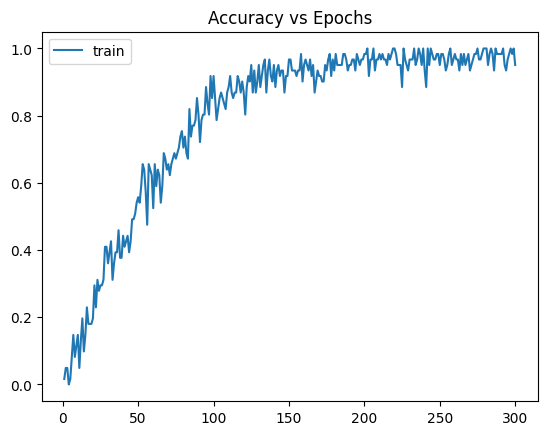

In [33]:
# Grafico del entrenamiento del modelo
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.title('Accuracy vs Epochs')
plt.show()

In [34]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

c:\Users\Federico Delgado\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 6 - Testing y validación

In [35]:
# Convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# Transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# Usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# Obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [36]:
# Funcion para iniciar el chatbot
def start_chat():
    print("Bienvenido al chatbot medico por favor ingrese una consulta.\n (Por favor ingrese 'salir' para abandonar el chat)")
    while True:
        # Pido input al usuario
        message = input("")
        print("Q:", message)
        if message.lower() == 'salir':
            break

        intents = pred_class(message, words, classes)
        if len(intents) > 0:
            result = get_response(intents, dataset)
            print("BOT:", result)
        else: # si no hubo ningún resultado que supere el umbral
            print("BOT: Perdón, no comprendo la pregunta.")

Chat 1

In [28]:
start_chat()

Bienvenido al chatbot medico por favor ingrese una consulta.
 (Por favor ingrese 'salir' para abandonar el chat)
Q: Hola
1/1 [==============================] - 0s 15ms/step
BOT: Hola!
Q: Nombre
1/1 [==============================] - 0s 19ms/step
BOT: Yo soy Nora un Chatbot medico
Q: Contacto
1/1 [==============================] - 0s 16ms/step
BOT: Contactos al whatsapp <numero>
Q: Chau
1/1 [==============================] - 0s 20ms/step
BOT: Hasta luego!
Q: Salir


Chat 2

In [22]:
start_chat()

Bienvenido al chatbot medico por favor ingrese una consulta.
 (Por favor ingrese 'salir' para abandonar el chat)
Q: ¿Como te llamas?
1/1 [==============================] - 0s 16ms/step
BOT: Yo soy Nora un Chatbot medico
Q: Fiebre
1/1 [==============================] - 0s 18ms/step
BOT: Para tratar la fiebre en casa: 1) Beba muchos lÃ­quidos para mantenerse hidratado. 2) Use una manta liviana si siente frÃ­o, hasta que pasen los escalofrÃ­os. 3) Tome ibuprofeno. 4) Busque ayuda mÃ©dica si la fiebre dura mÃ¡s de cinco dÃ­as seguidos o es muy elevada
Q: Diarrea
1/1 [==============================] - 0s 16ms/step
BOT: 1) Hidratar el cuerpo es esencial para recuperarse de la diarrea ya que la misma hace que el cuerpo pierda electrolitos como el sodio. 2) Es muy recomendable evitar los productos lÃ¡cteos, ya que pueden empeorar la diarrea en algunas personas. 3) Si la diarrea dura mÃ¡s de 2 dÃ­as, busque atenciÃ³n mÃ©dica para evitar complicaciones.
Q: Dolor de cabeza
1/1 [==================

Chat 3

In [20]:
start_chat()

Bienvenido al chatbot medico por favor ingrese una consulta.
 (Por favor ingrese 'salir' para abandonar el chat)
Q: Buen dia
1/1 [==============================] - 0s 19ms/step
BOT: Hola
Q: Congestión nasal
1/1 [==============================] - 0s 23ms/step
BOT: Cuando estÃ© congestionado, concÃ©ntrese en mantener hÃºmedos los conductos nasales y los senos paranasales. Para mantener hÃºmedos los conductos nasales, puede: 1) Usar un humidificador o vaporizador. 2) Beber muchos lÃ­quidos. Esto diluirÃ¡ la mucosidad, lo que podrÃ­a ayudar a prevenir la obstrucciÃ³n de los senos paranasales. 3) Coloque una toalla hÃºmeda y tibia en la cara. Puede aliviar la incomodidad y abrir las fosas nasales.
Q: Tos
1/1 [==============================] - 0s 18ms/step
BOT: Miel:- Use miel para tratar la tos, mezcle 2 cucharaditas con agua tibia o un tÃ© de hierbas. Beba esta mezcla una o dos veces al dÃ­a. No le dÃ© miel a niÃ±os menores de 1 aÃ±o.
Q: Dolor de garganta
1/1 [=============================

Chat 4

In [37]:
start_chat()

Bienvenido al chatbot medico por favor ingrese una consulta.
 (Por favor ingrese 'salir' para abandonar el chat)
Q: Buenas
1/1 [==============================] - 0s 46ms/step
BOT: Hola
Q: Esguince
1/1 [==============================] - 0s 22ms/step
BOT: Use una bolsa de hielo o un baÃ±o de hielo granizado inmediatamente durante 15 a 20 minutos y repita cada dos o tres horas mientras estÃ© despierto. Para ayudar a detener la hinchazÃ³n, comprima el tobillo con una venda elÃ¡stica hasta que cese la hinchazÃ³n. En la mayorÃ­a de los casos, el dolor los analgÃ©sicos, como el ibuprofeno o el paracetamol son suficientes para controlar el dolor de un esguince de tobillo
Q: Fractura
1/1 [==============================] - 0s 15ms/step
BOT: 1) Detenga cualquier sangrado. Aplique presiÃ³n a la herida con un vendaje estÃ©ril, un paÃ±o limpio o una prenda de vestir limpia. 2) Inmovilice el Ã¡rea lesionada. No intente realinear el hueso ni empuje un hueso que sobresale hacia atrÃ¡s. 3) Aplique bolsa

### 7 - Conclusiones

El bot tal cual está definido es capaz de responder a bastantes preguntas tipicas sobre lesiones medicas tipicas con gran precisión.

En el segundo chat al querer informacion de "Dolor de cabeza" el chat confunde la respuesta con la de "Dolor de garganta" y luego al uusar solo la palabra "cabeza" el chat no devuelve una respuesta correcta. Para solucionar el inconveniente de la palabra "dolor" que aparece en varios tags del archivo JSON se podria simplificar dicho tag a palabras mas genericas al estilo "Cabeza", "muela", "garganta".
 
Se podría decir que la desventaja principal de este bot es que las respuestas son bastante genéricas ya que las selecciona desde las responses predefinidas en el JSON. Además, si se hace una consulta con palabras que no se encuentran dentro de los patrones del JSON, no habrá una buena respuesta. Por lo tanto, una manera de mejorarlo es pensar en muchos casos de uso y generar un JSON más completo.